In [1]:
import torch 
import torch.nn as nn
import torch.utils.data as Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
num_of_feature = 13
featrues_name13= ['a','delta','Tm','D_Tm','Hmix','σHmix','Sid','Elec_nega','D_elec_nega','VEC','d_VEC','BulkModulus','D_Bulk']
BS = 20
LR = 0.001
EPOCHS = 30
HIDDEN = 55
dataset ='AM'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
x_train = np.load('data/x_train.npy') #420,13
x_val = np.load('data/x_val.npy')     #91
x_test = np.load('data/x_test.npy')   #90
y_train = np.load('data/y_train_' + dataset + '.npy')
y_val = np.load('data/y_val_' + dataset + '.npy')
y_test = np.load('data/y_test_' + dataset + '.npy')
data_pred = np.load('data/for_pred.npy')

In [4]:
def get_model(hidden):
    return nn.Sequential(
                        nn.Linear(num_of_feature, hidden),
                        nn.Sigmoid(),
                        nn.Linear(hidden,1),
                        nn.Sigmoid(),)
net = get_model(HIDDEN).to(device)

In [5]:
optimizer = torch.optim.Adam(net.parameters(),lr=LR)
criterion = nn.BCELoss()

In [6]:
def transform_data(x, y=None):
    inputs = torch.tensor(x).to(device)
    if y is None:    
        dataset = Data.TensorDataset(inputs)
    else:
        labels = torch.tensor(y).to(device) 
        dataset = Data.TensorDataset(inputs, labels)
    loader = Data.DataLoader(dataset, batch_size=BS, shuffle=True)
    return loader

train_loader = transform_data(x_train,y_train)
val_loader = transform_data(x_val, y_val)
test_loader = transform_data(x_test, y_test)
pred_loader = transform_data(data_pred)

In [7]:
def fit(model, xiter, criterion, optimizer, is_train=False):
    acc, total_loss, n = 0, 0, 0
    for xb, yb in xiter:
        yb = yb.view(-1,1)    # 这里是为了让标签变成一个二维张量，进行的升维
        inputs = xb.to(device).type(torch.float32)
        targets = yb.to(device).type(torch.float32)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        pred = outputs.round()
        acc += torch.sum((pred == targets))
        total_loss += loss.item()
        n += len(yb)
    return acc.float()/n, total_loss/n

In [8]:
losses, accs = [], []
val_losses, val_accs = [], []
def training(epochs, model, train_iter, valid_iter, criterion, optimizer, flag=True):
    for epoch in range(epochs):
        epoch_loss, epoch_acc = 0, 0
        val_epoch_loss, val_epoch_acc = 0, 0
        model.train()
        epoch_acc, epoch_loss = fit(model, train_iter, criterion, optimizer, True)
        losses.append(epoch_loss)
        accs.append(epoch_acc)
        if flag:
            print("[{}/{}] \ntraining loss:\t {:.4f}   training acc:\t{:.2f}%".format(epoch+1, epochs, epoch_loss, epoch_acc*100))

        if valid_iter:
            with torch.no_grad():
                model.eval()
                val_epoch_acc, val_epoch_loss = fit(model, valid_iter, criterion, optimizer)
            val_losses.append(val_epoch_loss)
            val_accs.append(val_epoch_acc)
            if flag:
                print("validation loss: {:.4f}   validation acc: {:.2f}%".format(val_epoch_loss,val_epoch_acc*100))

In [9]:
%%time
training(EPOCHS, net, train_loader, val_loader, criterion, optimizer)

[1/30] 
training loss:	 0.0380   training acc:	33.33%
validation loss: 0.0374   validation acc: 63.74%
[2/30] 
training loss:	 0.0315   training acc:	71.19%
validation loss: 0.0341   validation acc: 67.03%
[3/30] 
training loss:	 0.0286   training acc:	72.38%
validation loss: 0.0322   validation acc: 67.03%
[4/30] 
training loss:	 0.0272   training acc:	72.38%
validation loss: 0.0325   validation acc: 67.03%
[5/30] 
training loss:	 0.0263   training acc:	72.38%
validation loss: 0.0302   validation acc: 67.03%
[6/30] 
training loss:	 0.0253   training acc:	72.38%
validation loss: 0.0293   validation acc: 67.03%
[7/30] 
training loss:	 0.0244   training acc:	72.38%
validation loss: 0.0283   validation acc: 68.13%
[8/30] 
training loss:	 0.0235   training acc:	76.19%
validation loss: 0.0270   validation acc: 76.92%
[9/30] 
training loss:	 0.0225   training acc:	77.62%
validation loss: 0.0269   validation acc: 76.92%
[10/30] 
training loss:	 0.0216   training acc:	78.81%
validation loss: 0

In [10]:
# %%time
# for hid in range(10,80,5):
#     net = get_model(hid).to(device)
#     optimizer = torch.optim.Adam(net.parameters(),lr=LR)
#     training(EPOCHS, net, train_loader, val_loader, criterion, optimizer, False)
#     acc = 0
#     acc, _ = fit(net, test_loader, criterion, optimizer)
#     print("hidden: {}, the Model test score: {}".format(hid, acc.item()))

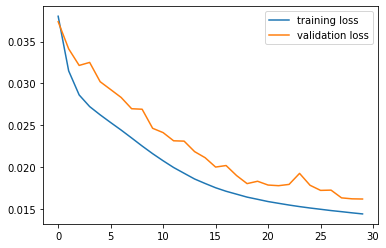

In [11]:
plt.plot(losses,label='training loss')
plt.plot(val_losses,label="validation loss")
plt.legend() 

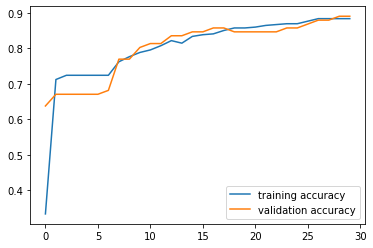

In [12]:
plt.plot(accs,label="training accuracy")
plt.plot(val_accs,label="validation accuracy")
plt.legend()

In [13]:
# 使用test最后来评估模型
acc, _ = fit(net, test_loader, criterion, optimizer)
print("the Model test score: ",acc.item())

the Model test score:  0.8888888955116272


In [14]:
parameters = list(net.parameters())

In [15]:
Sensitivity = parameters[2].mm(parameters[0]).cpu().data.numpy()

In [16]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
normal_s = scaler.fit_transform(Sensitivity.T)

In [17]:
sensitivity = np.squeeze(normal_s).tolist()

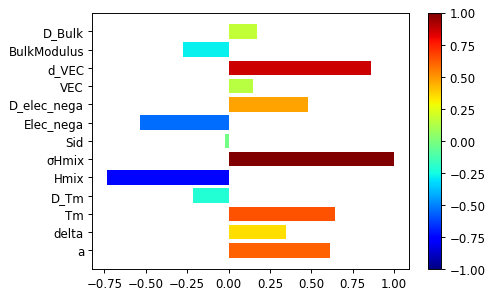

In [18]:
plt.rcParams['savefig.dpi'] = 100 #图片像素
plt.rcParams['figure.dpi'] = 85 #分辨率
norm = plt.Normalize(-1,1)
norm_values = norm(sensitivity)
map_vir = cm.get_cmap(name='jet')
colors = map_vir(norm_values)
sm = cm.ScalarMappable(cmap=map_vir,norm=norm)  # norm设置最大最小值
plt.figure()
plt.colorbar(sm)
plt.barh(featrues_name13, sensitivity, color=colors)
plt.show()

1. 出现了一个问题就是None如何让程序意识到<br>
2. 第二个就是关于RuntimeError: CUDA error: device-side assert triggered<br>
<font color=red><b>这是因为我使用了crossentropyloss,但是输出只有一个维度,即只有一个神经元,后来换成两个就没有问题</font></b><br>
3. <font size=5>炼丹时间到</font>
4. 很奇怪敏感矩阵与文献不一样,不过符号是一样的，问题就不大了。<br>
P.S. 今天（5.12）下载了另一个文件。发现它的Sensitivity Matrix，10次运行的结果都不一样，它是取了<b>平均值</b>！！那么我这个结果无所谓了，重点还是让符号和文献对应。
    - 其中SS第4个由于数字比较小一般可以忽略。但是重点就是最后一个符号完全相反！<br>
    - IM的第5个比较小也可以忽略。还有9、12符号相反<br>
    - AM的第7个比较小可以忽略，第9个符号相反
5. 由于文献最后是1个神经元输出,所以依照它,就不能使用cross entropy loss交叉熵
6. <font color=blue><b>torch中一个非常重要的函数round进行四舍五入，这我之前是没有想到的。由于使用BCELoss就必须要让sigmoid输出就变为标签所有就需要四舍五入</font></b>但是四舍五入毕竟是一般情况，正确做法应该是设置一个阈值，自动学习获得，当然通常我们也默认阈值为0.5。
7. 绘制最后的这个图真的是吐血，因为plt.normalize这个函数传入的参数就vmax、vmin会将大于这个值的数变成这个值？？？？太蠢了
8. markdown有序列表加`.`，然后如果要嵌套列表就需要加入四个空格 `tab`